<h1><center> NeuroML-DB Analysis - Clustering of channel models </h1></center>

In [12]:
from ast import literal_eval
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import euclidean as dist
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
import xml.etree.ElementTree as ET
import os
from collections import OrderedDict

from IPython.display import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

# There are Deprecation issues with python 2.7
# Don't print these
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from analyses.clustering import compute_protocol_pca, compute_icg_scores

In [2]:
cwd = os.getcwd()
path2save = os.path.join(cwd,'data')
path2figs = os.path.join(cwd,'figures')


# Load normalized traces for clustering

In [3]:
# load everything
filename = os.path.join(path2save,'norm_cav_responses.csv')
norm_cav_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_ih_responses.csv')
norm_ih_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_kca_responses.csv')
norm_kca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_kv_responses.csv')
norm_kv_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_nav_responses.csv')
norm_nav_df = pd.read_csv(filename,index_col=0)



In [4]:
# add Channel_Type just in case I group all together
norm_cav_df['Channel_Type'] = pd.Series(['Cav' for i in norm_cav_df.index.values])
norm_ih_df['Channel_Type'] = pd.Series(['Ih' for i in norm_ih_df.index.values])
norm_kca_df['Channel_Type'] = pd.Series(['KCa' for i in norm_kca_df.index.values])
norm_kv_df['Channel_Type'] = pd.Series(['Kv' for i in norm_kv_df.index.values])
norm_nav_df['Channel_Type'] = pd.Series(['Nav' for i in norm_nav_df.index.values])



In [5]:
samples = [str(i) for i in range(5632)]
example_df = norm_cav_df[samples]



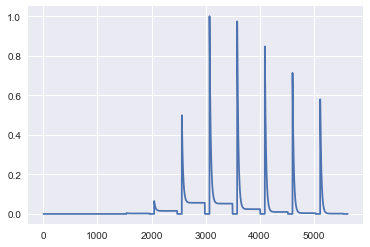

In [6]:
plt.plot(example_df.values[0])



In [7]:
def plot_pca(pc_df,show_type=False):
    
    fig, ax = plt.subplots(1,3,figsize=(18, 6))
    ax = ax.flatten()

    which_pcs = [(1,2),(1,3),(2,3)]
    total_pc_channels = len(pc_df.index.values)
    
    colors = ['r','b','y','g']

    for ax_id, (x_axis,y_axis) in enumerate(which_pcs):
        x_pc = 'PC '+str(x_axis)
        y_pc = 'PC '+str(y_axis)

        ax[ax_id].scatter(pc_df.loc[:, x_pc],
                   pc_df.loc[:, y_pc],
                   c = 'r', s = 50,
                   alpha=0.8,edgecolors='gray')


        ax[ax_id].set_xlabel(x_pc)
        ax[ax_id].set_ylabel(y_pc)

    return fig, ax



## Voltage-gated calcium current clusters

In [9]:
norm_cav_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,NMLCH000014,ACTIVATION,Cav
1,0.024395,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.159074,0.159078,0.159082,0.159086,0.159090,0.159094,0.159098,NMLCH000014,DEACTIVATION,Cav
2,0.002124,0.883331,1.000000,0.996459,0.985908,0.975225,0.964542,0.954000,0.943549,0.933185,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,NMLCH000014,INACTIVATION,Cav
3,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,NMLCH000017,ACTIVATION,Cav
4,0.025858,0.000005,0.000005,0.000006,0.000006,0.000006,0.000006,0.000007,0.000007,0.000007,...,0.167979,0.167990,0.168002,0.168014,0.168025,0.168037,0.168048,NMLCH000017,DEACTIVATION,Cav


### Need to get num_pcs that explain 99% of the variance

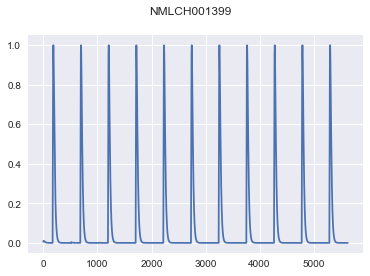

In [10]:
which_trace = 14
plt.plot(norm_cav_df[norm_cav_df['Protocol_ID']=='INACTIVATION'].iloc[which_trace].values[:-3])
plt.suptitle(norm_cav_df[norm_cav_df['Protocol_ID']=='INACTIVATION']['Model_ID'].iloc[which_trace]);

ACTIVATION


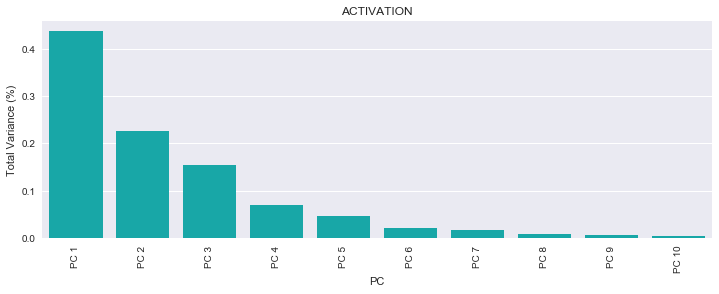

DEACTIVATION


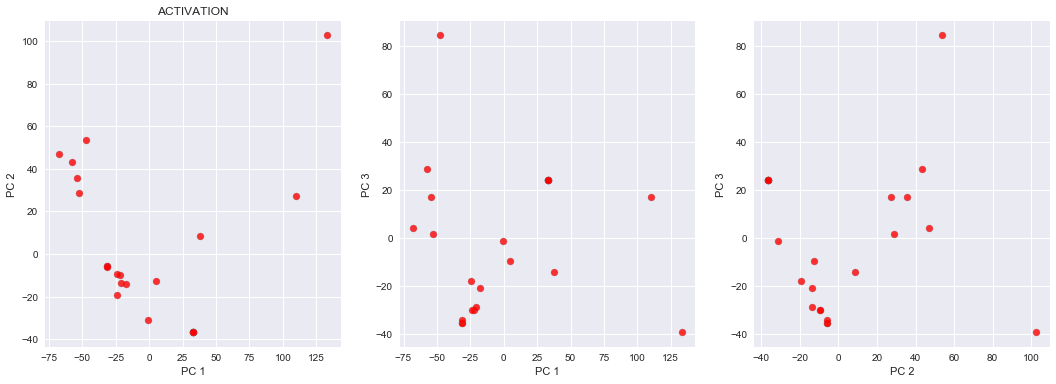

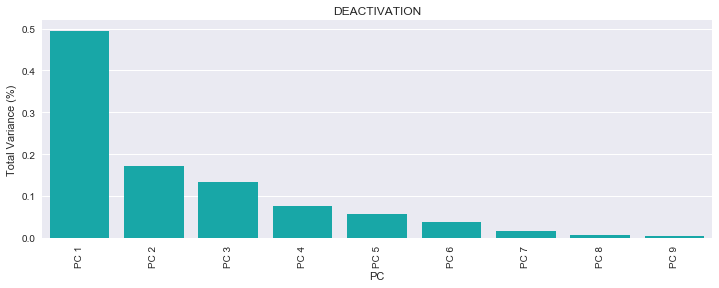

INACTIVATION


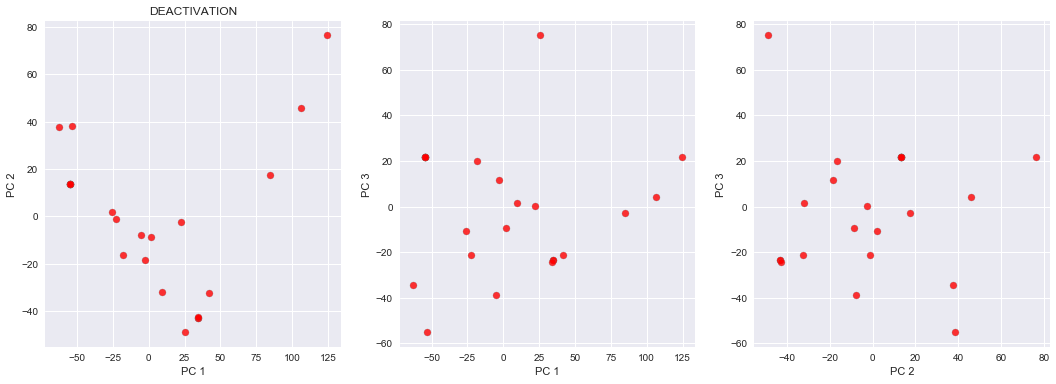

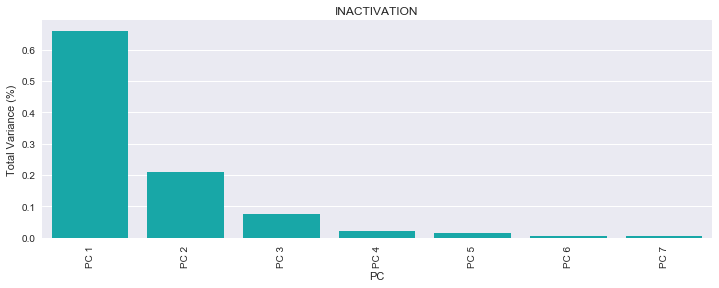

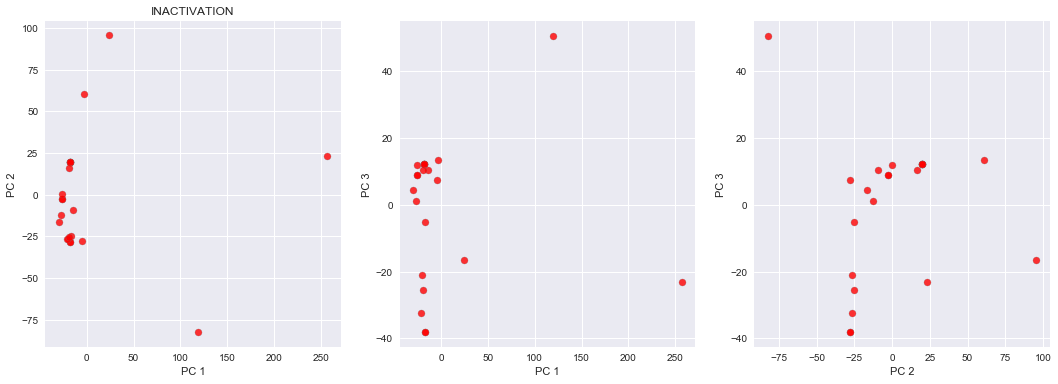

In [13]:
pca_df = norm_cav_df # perform on normalized responses
protocols = ['ACTIVATION','DEACTIVATION','INACTIVATION']

pc_dfs = []
pcas = []
pcs = []

# compute pca and plot
for protocol_id in protocols:
    print(protocol_id)
    pc_df, pca, pc, _ = compute_protocol_pca(pca_df,protocol_id,plots=True)
    
    # collect all
    pc_dfs.append(pc_df)
    pcas.append(pca)
    pcs.append(pc)
    
    
    fig, ax = plot_pca(pc_df=pc_df)
    
    ax[0].set_title(protocol_id)
    
    

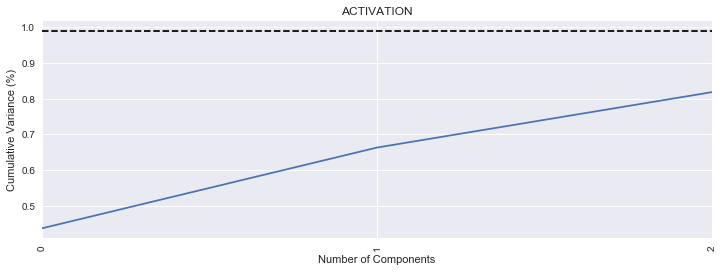

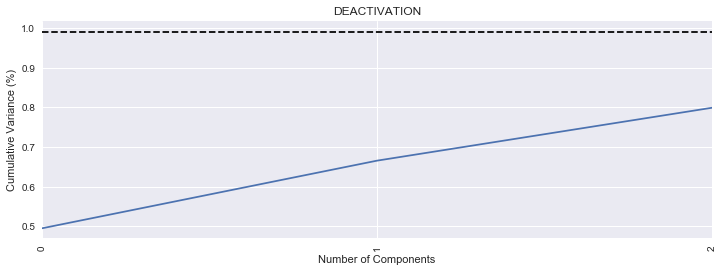

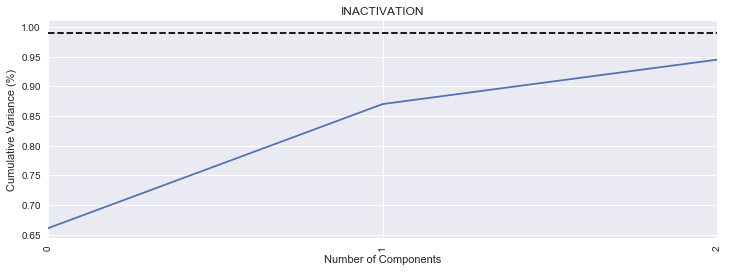

In [16]:
desired_num_pcs = []

for protocol_id, pc_df, pca, pc in zip(protocols,pc_dfs,pcas,pcs):

    #Plotting the Cumulative Summation of the Explained Variance
    fig = plt.figure(figsize=(12,4))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.plot(0.99*np.ones_like(np.cumsum(pca.explained_variance_ratio_)),'k--')

    # clean plot
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance (%)') #for each component
    plt.xlim([0,num_pcs-1])
    plt.xticks(range(num_pcs),rotation='vertical')
    plt.title(protocol_id)

    plt.show()
    
    # get num_pcs that satisfy criterion for explained_variance_ratio
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    criterion = .99
    criterion_met = np.where(cumsum>criterion)[0][0]
    
    desired_num_pcs.append(criterion_met)
    
#     print(np.cumsum(pca.explained_variance_ratio_)[9]) # activation num_pcs
#     print(np.cumsum(pca.explained_variance_ratio_)[8]) # deactivation num_pcs
#     print(np.cumsum(pca.explained_variance_ratio_)[6]) # inactivation num_pcs

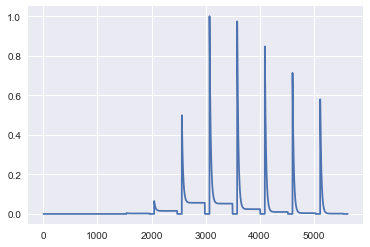

In [17]:
plt.plot(norm_cav_df.loc[0].values[:-3]);

# Automated scoring based on ICGenealogy protocols

In [18]:
def compute_icg_scores(norm_responses_df,protocols=['ACTIVATION','DEACTIVATION','INACTIVATION'],num_identifiers=3):
    '''
        Skipped first normalization. Include that afterward. Every channel response is reduced to a
        3-dimensional score vector (1 point per protocol or 3 PCs). 
    
    '''
    
    #### STEP 1) Perform PCA with number PCs to retain 99% explained variance
    pca_df = norm_responses_df.copy() # perform on normalized responses

    pc_dfs = []
    pcas = []
    pcs = []
    score_samples = []

    # compute pca and plot
    for protocol_id in protocols:
        pc_df, pca, pc, scores = compute_protocol_pca(pca_df,protocol_id)

        # collect all
        pc_dfs.append(pc_df)
        pcas.append(pca)
        pcs.append(pc)
        score_samples.append(scores)
        
        
    
    #### STEP 2) Normalize condition score vectors (create one score vector per model per protocol)
    final_score_vector = [] # contains all scores = the log-likelihood of samples

    # iterate over protocols
    for i, (score_vector,protocol_id) in enumerate(zip(score_samples,protocols)):

        # normalize the protocol-specific scores by dividing each protocol by std of entries
        condition_scores = score_vector/np.std(score_vector)
        final_score_vector.append(condition_scores) # combined
    
    
    
    
    # !--- this may be wrong below. Is this supposed to be a matrix or a vector
    
    #### Step 3) Combine all condition vectors
    final_score_mat = np.array(final_score_vector).T
    
    # dataframe to store score vectors in
    columns = protocols
    protocol_scores_df = pd.DataFrame(columns=columns)

    for col_i, col in enumerate(columns):
        protocol_scores_df[col] = pd.Series(final_score_mat[:,col_i])
        
            

    
    #### Step 4) Perform PCA again to get final score vector for each model (3 PCs)
    final_pc_df, final_pca, final_pcs, final_scores = compute_protocol_pca(protocol_scores_df,drop_cols=None)

    
    # template from original response dataframe
    df = norm_responses_df[norm_responses_df['Protocol_ID']=='ACTIVATION']

    
    channel_models = df.Model_ID.values
    channel_types = df.Channel_Type.values
    
    # final score vector should be the same length as the number of models  
    final_scores_df = final_pc_df.copy()
    final_scores_df['Model_ID'] = pd.Series(channel_models)
    final_scores_df['Channel_Type'] = pd.Series(channel_types)
    



    return final_scores_df

In [67]:
cav_scores_df = compute_icg_scores(norm_responses_df=norm_cav_df)

# save final scores
filename = os.path.join(path2save,'final_scores_cav.csv')
cav_scores_df.to_csv(filename)



In [68]:
cav_scores_df.tail()

,PC 1,PC 2,PC 3,Model_ID,Channel_Type
19,2.852699,-0.182043,0.006882,NMLCH001586,Cav
20,-0.085649,1.053539,0.336204,NMLCH001591,Cav
21,1.189513,2.261119,-1.050049,NMLCH001598,Cav
22,0.273375,-0.380382,-0.264160,NMLCH001607,Cav
23,2.889648,-1.780468,-0.140643,NMLCH001632,Cav


In [72]:
ih_scores_df = compute_icg_scores(norm_responses_df=norm_ih_df)

# save final scores
filename = os.path.join(path2save,'final_scores_ih.csv')
ih_scores_df.to_csv(filename)



In [ ]:
kca_scores_df = compute_icg_scores(norm_responses_df=norm_kca_df)

# save final scores
filename = os.path.join(path2save,'final_scores_kca.csv')
kca_scores_df.to_csv(filename)


In [73]:
kv_scores_df = compute_icg_scores(norm_responses_df=norm_kv_df)

# save final scores
filename = os.path.join(path2save,'final_scores_kv.csv')
kv_scores_df.to_csv(filename)



In [74]:
nav_scores_df = compute_icg_scores(norm_responses_df=norm_nav_df)

# save final scores
filename = os.path.join(path2save,'final_scores_nav.csv')
nav_scores_df.to_csv(filename)


<hr>

## Start Here if just performing clustering

In [19]:
# load everything
filename = os.path.join(path2save,'final_scores_cav.csv')
cav_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_ih.csv')
ih_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_kca.csv')
kca_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_kv.csv')
kv_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_nav.csv')
nav_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_kca.csv')
kca_scores_df = pd.read_csv(filename,index_col=0)



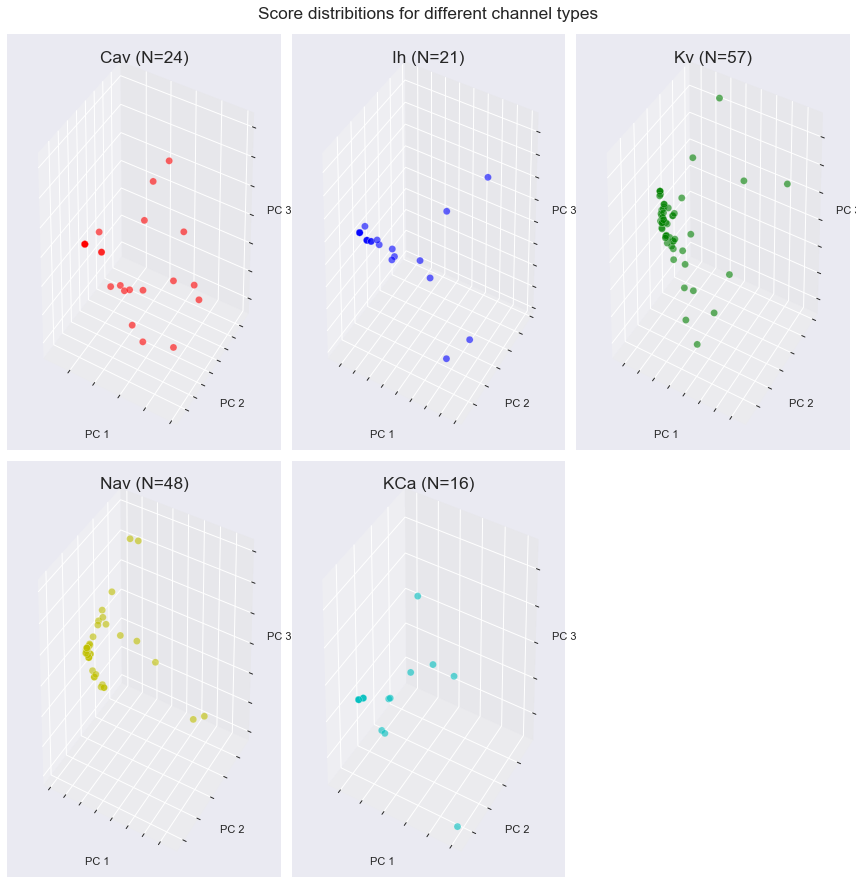

In [20]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df,kca_scores_df]
titles = ['Cav','Ih','Kv','Nav','KCa']
colors = ['r','b','g','y','c']

# show 3D scatter for each of the channel types
fig = plt.figure(figsize=(12,12))


for i, df in enumerate(dfs):

    ax = fig.add_subplot(2,3,i+1, projection='3d')

    xs = df['PC 1']
    ys = df['PC 2']
    zs = df['PC 3']

    ax.scatter(xs, ys, zs, s=50, c=colors[i], alpha=0.6, edgecolors='w')


    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    num_models = len(xs)
    ax.set_title(titles[i]+' (N=%s)' %num_models,size='xx-large')


fig.tight_layout()
fig.suptitle('Score distribitions for different channel types',y=1.02,size='xx-large')

filename = 'specific_score_clusters'
path2file = os.path.join(path2images,filename)
plt.savefig(path2file,bbox_inches='tight')

## Dendrogram visualizations

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [25]:
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df = pd.read_csv(filename,index_col=0)



In [26]:
channel_tags_df.head()



,Model_ID,Model_Name,Filename
0,NMLCH000001,Ih Hyperpolarization Activated Cation,hd.nml
1,NMLCH000002,IA A Type Potassium Channel for Distal Dendrites,kad.nml
2,NMLCH000003,IA A Type Potassium,kap.nml
3,NMLCH000004,KDr Delayed Rectifier Potassium,kdr.nml
4,NMLCH000005,Na Sodium,na3.nml


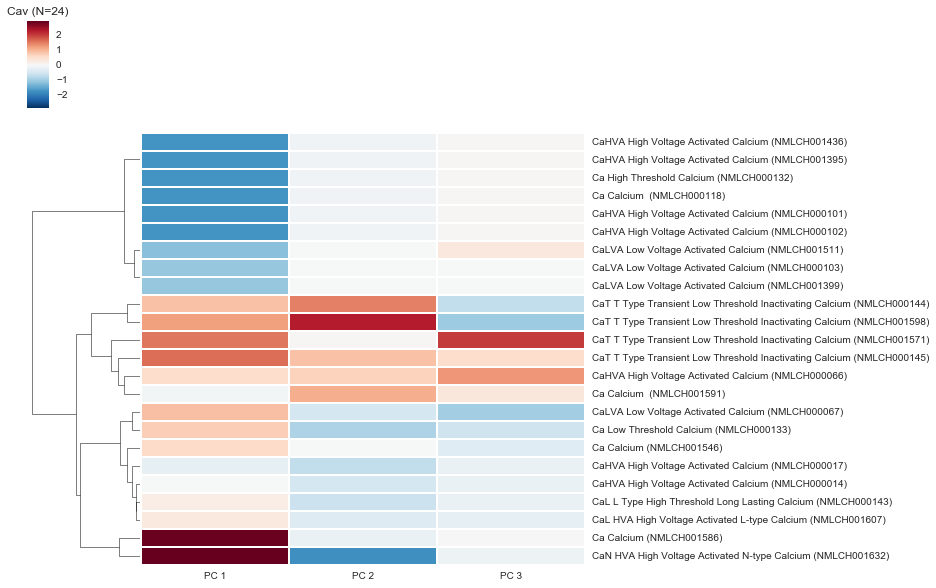

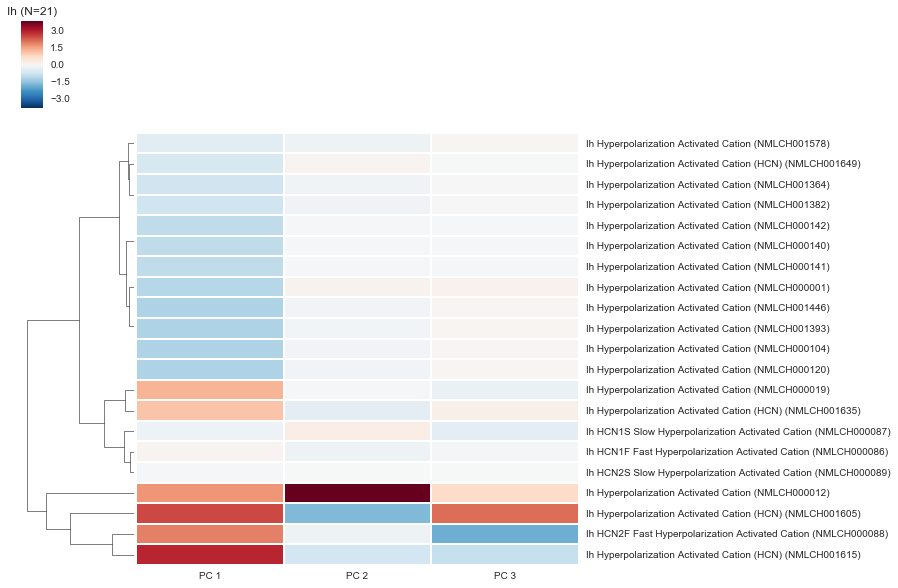

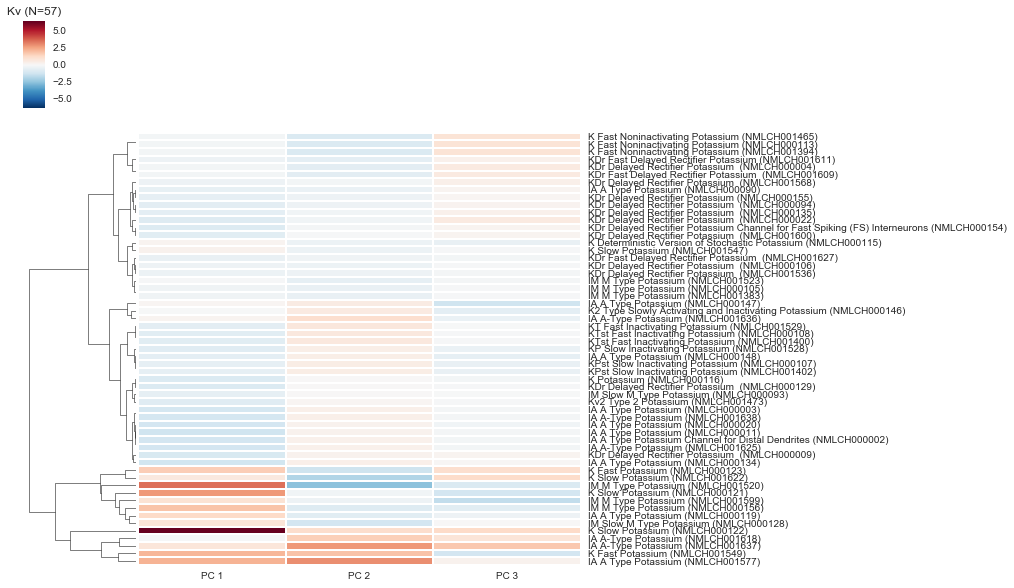

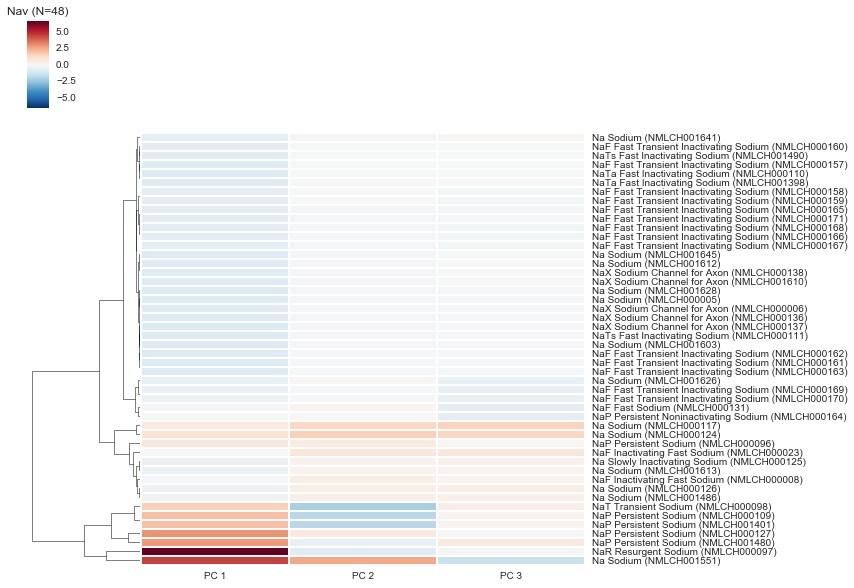

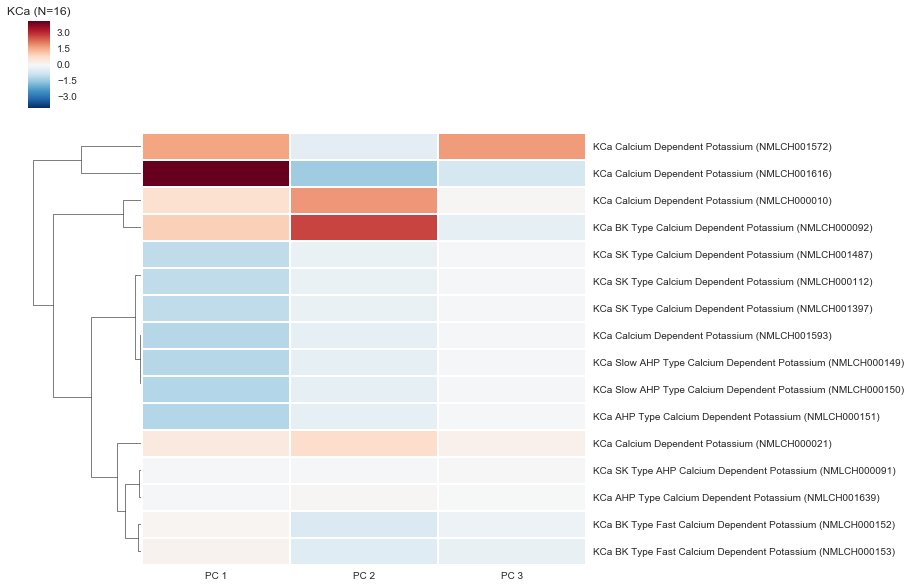

In [27]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df,kca_scores_df]
titles = ['Cav','Ih','Kv','Nav','KCa']


dendrograms = []

for i, df in enumerate(dfs):
    
    fig = plt.figure(figsize=(16,14),dpi=300)

    temp_df = df.copy()
    models = temp_df.pop('Model_ID')
    model_names = channel_tags_df[channel_tags_df['Model_ID'].isin(models)]['Model_Name'].values.tolist()
    channel = temp_df.pop('Channel_Type')
    
    # Calculate the distance between each sample (linkage_matrix)
    link = 'ward'
    Z = linkage(temp_df,link) # default = 'ward'
    
    leaves = []
    
    for nmldb_id, name in zip(models,model_names):
        leaves.append(name + ' ('+ nmldb_id + ')')

    
    clm = sns.clustermap(temp_df, # inherits from above -- metric='Euclidean',method='ward',
                         row_linkage=Z,
                         linewidths=1,
                         col_cluster=False,
                         yticklabels=leaves)
    

    
    
    plt.setp(clm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
    plt.title(titles[i]+' (N=%s)' %len(models))
    
    filename = titles[i]+'_clustermap_'+link+'_link'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,bbox_inches='tight')
    
    plt.show()

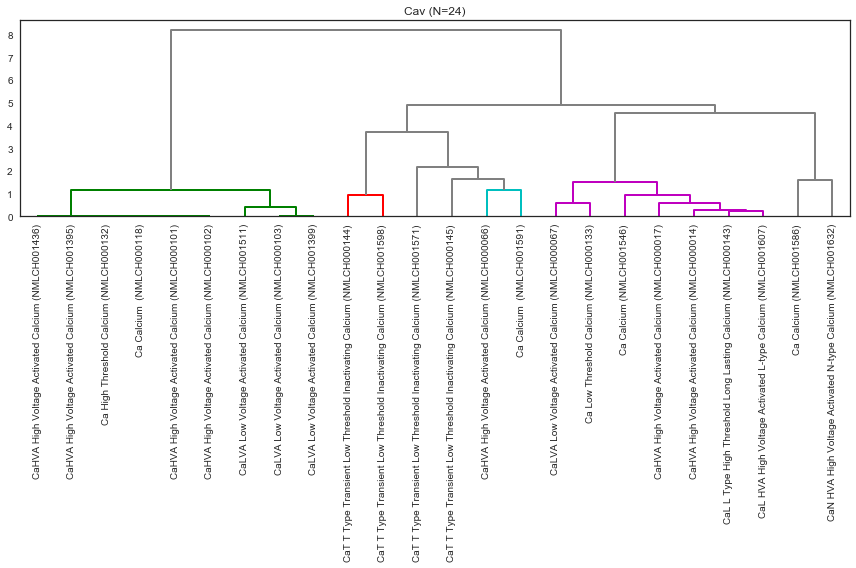

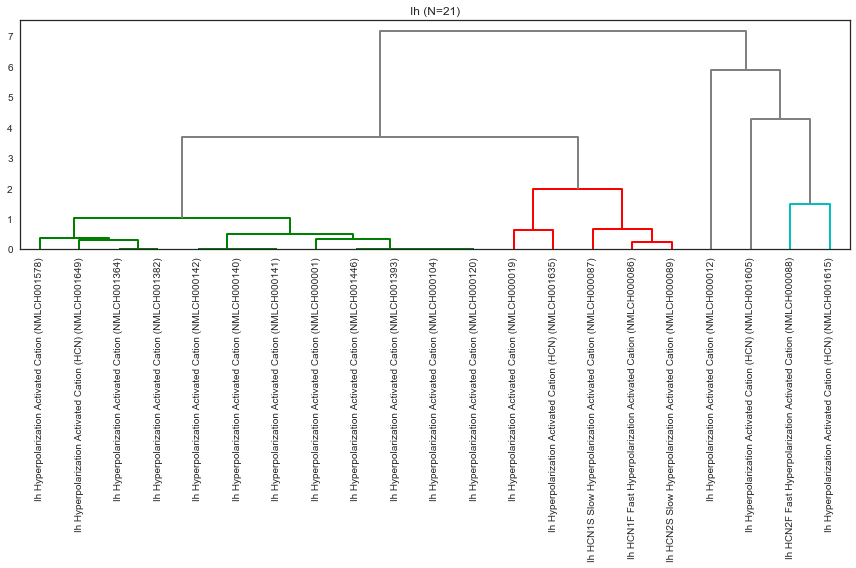

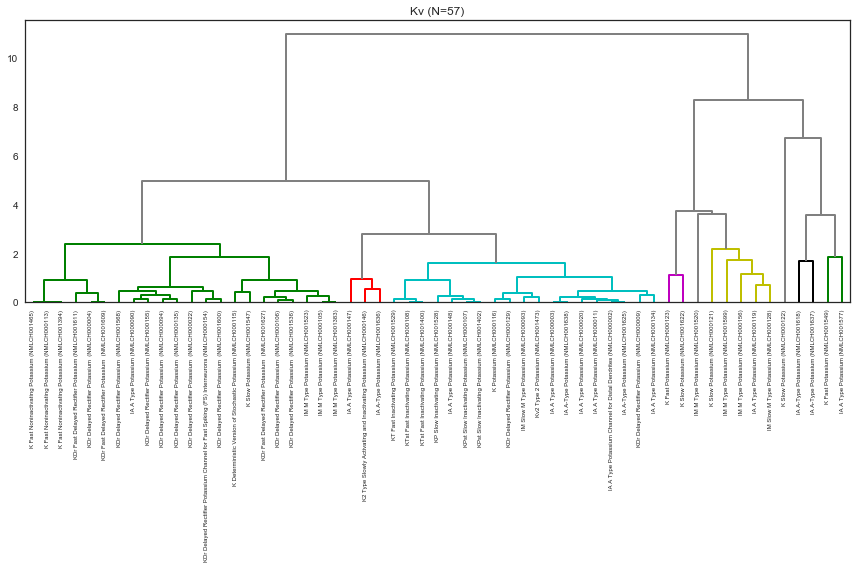

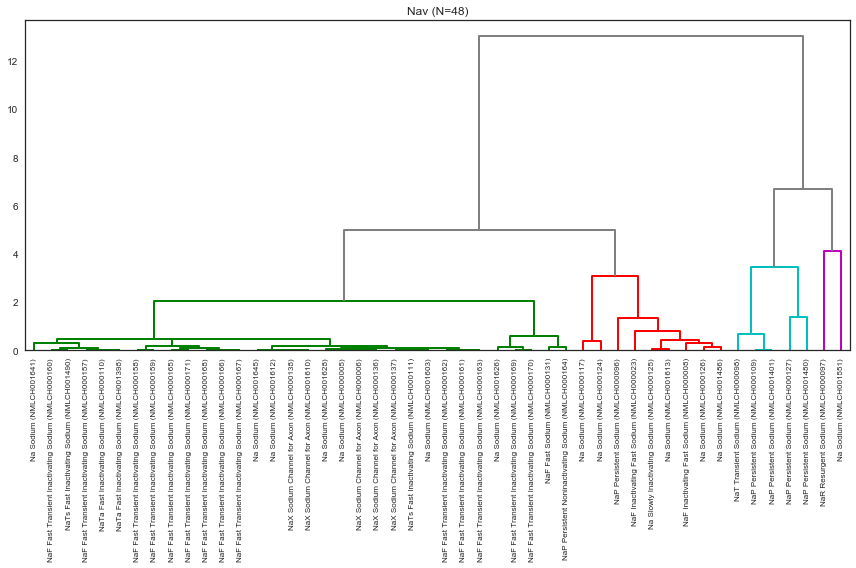

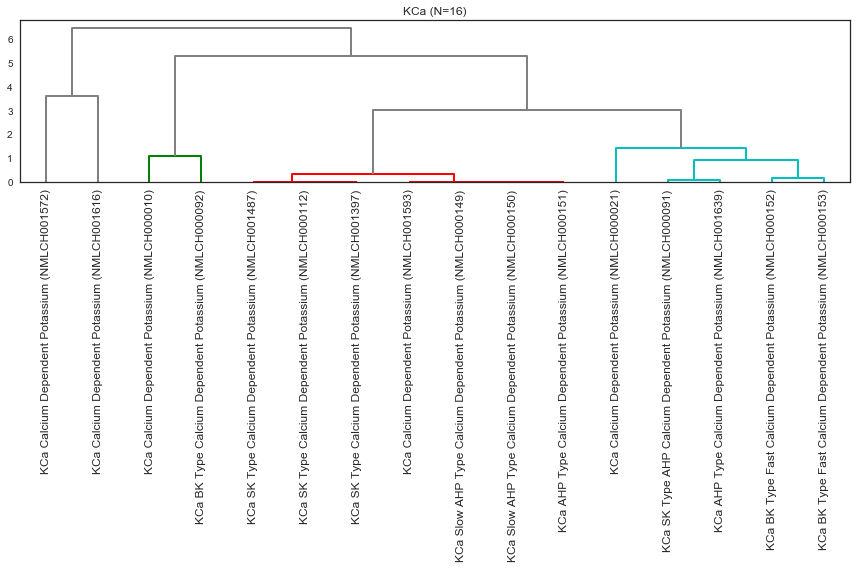

In [44]:
sns.set_style("white")

dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df,kca_scores_df]
titles = ['Cav','Ih','Kv','Nav','KCa']
thresholds = [1.5,3,2.5,4.5,2]

dendrograms = []

for i, df in enumerate(dfs):
    
    fig = plt.figure(figsize=(12,8))
#     fig = plt.figure(figsize=(6,6))

    temp_df = df.copy()
    models = temp_df.pop('Model_ID')
    model_names = channel_tags_df[channel_tags_df['Model_ID'].isin(models)]['Model_Name'].values.tolist()
    channel = temp_df.pop('Channel_Type')
    
    # Calculate the distance between each sample (linkage_matrix)
    link = 'ward'
    Z = linkage(temp_df,link)
    
    leaves = []
    
    for nmldb_id, name in zip(models,model_names):
        leaves.append(name + ' ('+ nmldb_id + ')')

    import matplotlib
    matplotlib.rcParams['lines.linewidth'] = 2
    
    # Make the dendro
    dend = dendrogram(Z, labels=leaves, #no_labels = True,
                      leaf_rotation=90, orientation="top", 
                      color_threshold=thresholds[i], above_threshold_color='grey')
    
    dendrograms.append(dend)
    
    
    plt.title(titles[i]+' (N=%s)' %len(models))
    plt.tight_layout()
    
    filename = titles[i]+'_dend_'+link+'_link_wlabels'
    path2file = os.path.join(path2figs,filename)
    plt.savefig(path2file,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()
    
    

### Redone with HDBSCAN (used to get final number of clusters in run_channel_clustering.py)

In [28]:
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage

In [29]:
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df = pd.read_csv(filename,index_col=0)



In [30]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df,kca_scores_df]

titles = ['Cav','Ih','Kv','Nav','Kca']
clusterers = []

for i, df in enumerate(dfs):

    temp_df = df.copy()
    models = temp_df.pop('Model_ID')
    model_names = channel_tags_df[channel_tags_df['Model_ID'].isin(models)]['Model_Name'].values.tolist()
    channel = temp_df.pop('Channel_Type')
    
    temp_df['Cluster'] = -1
    
    leaves = []
    
    for nmldb_id, name in zip(models,model_names):
        leaves.append(name + ' ('+ nmldb_id + ')')
    
    
    # do the clustering
    min_cluster_size = 2
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                approx_min_span_tree=True,
                                gen_min_span_tree=True)
    
    clusterer.fit_predict(temp_df)
    clusterers.append(clusterer)
    
    df['Cluster'] = clusterer.labels_
    


In [31]:
cav_clusters_df = cav_scores_df[['Model_ID','Cluster']].copy()
ih_clusters_df = ih_scores_df[['Model_ID','Cluster']].copy()
kv_clusters_df = kv_scores_df[['Model_ID','Cluster']].copy()
nav_clusters_df = nav_scores_df[['Model_ID','Cluster']].copy()



In [32]:
clusters_dfs = [cav_clusters_df,ih_clusters_df,kv_clusters_df,nav_clusters_df]

for clusters_df in clusters_dfs:
    
    names = []
    clusters_df['Model_Name'] = ''
    
    for i, model_id in enumerate(clusters_df['Model_ID'].values):

        model_name = channel_tags_df[channel_tags_df['Model_ID']==model_id]['Model_Name'].iloc[0]
        names.append(model_name)

    clusters_df['Model_Name'] = names
    
  

In [33]:
nav_clusters_df[nav_clusters_df['Cluster']==4]



,Model_ID,Cluster,Model_Name
28,NMLCH000166,4,NaF Fast Transient Inactivating Sodium
29,NMLCH000167,4,NaF Fast Transient Inactivating Sodium
30,NMLCH000168,4,NaF Fast Transient Inactivating Sodium


In [95]:
import seaborn as sns



In [98]:
cav_clusterer = clusterers[0]
ih_clusterer = clusterers[1]
kv_clusterer = clusterers[2]
nav_clusterer = clusterers[3]


/Users/vrhaynes/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


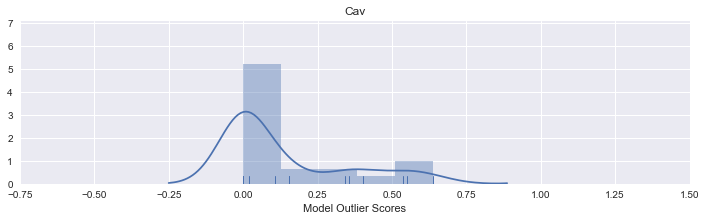

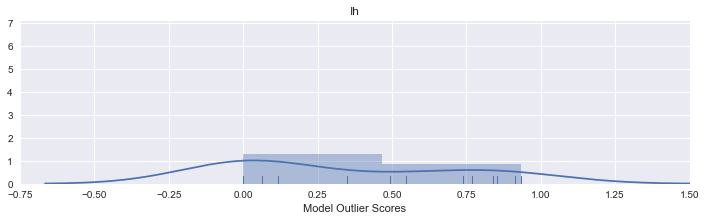

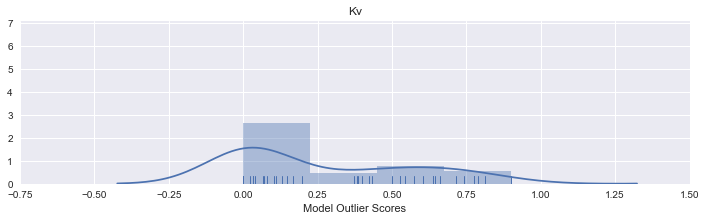

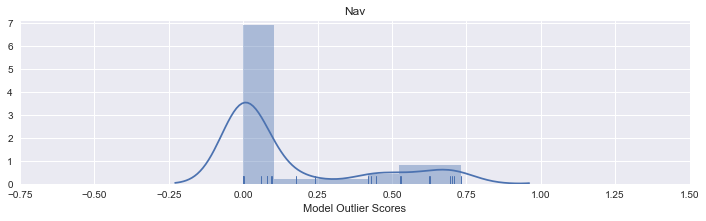

In [108]:
channel_types = ['Cav','Ih','Kv','Nav']

for channel, clusterer in zip(channel_types,clusterers):
    fig = plt.figure(figsize=(12,3))
    dp = sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
    
    plt.ylim([0,7.1])
    plt.xlim([-.75,1.5])
    plt.xlabel('Model Outlier Scores')
    plt.title(channel)

/Users/vrhaynes/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


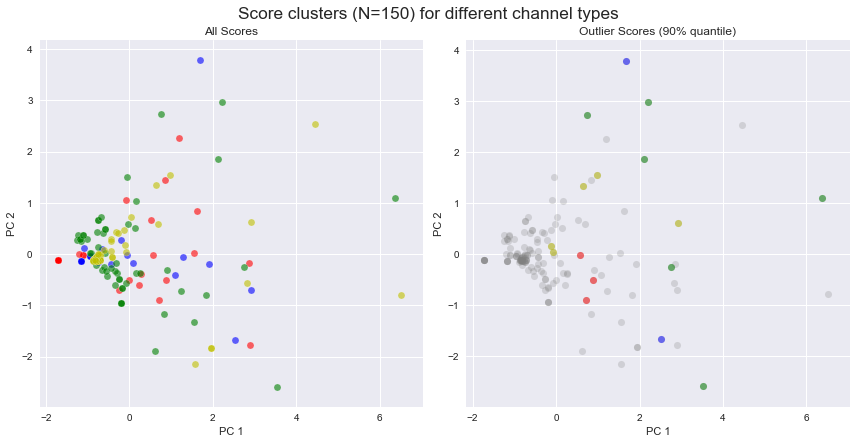

In [119]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df]
titles = ['Cav','Ih','Kv','Nav']
colors = ['r','b','g','y']

# show 3D scatter for each of the channel types
fig, axs = plt.subplots(1,2,figsize=(12,6))

num_models = 0

for i, (clusterer,df) in enumerate(zip(clusterers,dfs)):


    xs = df['PC 1']
    ys = df['PC 2']
    zs = df['PC 3']
    
    # all
    axs[0].scatter(xs, ys, s=50, c=colors[i], alpha=0.6, edgecolors='w')
    
    
    # only outliers
    threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    axs[1].scatter(xs,ys, s=50, linewidth=0, c='gray', alpha=0.25)
    axs[1].scatter(xs[outliers],ys[outliers], s=50, linewidth=0, c=colors[i], alpha=0.5)


    axs[0].set_xlabel('PC 1')
    axs[0].set_ylabel('PC 2')
    axs[1].set_xlabel('PC 1')
    axs[1].set_ylabel('PC 2')

    num_models += len(xs)
    
    axs[0].set_title('All Scores')
    axs[1].set_title('Outlier Scores (90% quantile)')


fig.tight_layout()
fig.suptitle('Score clusters (N=%s) for different channel types' %num_models,y=1.02,size='xx-large')

plt.show()


# Exemplar traces for different cluster groups

In [331]:
norm_cav_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,NMLCH000014,ACTIVATION,Cav
1,0.024395,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.159074,0.159078,0.159082,0.159086,0.159090,0.159094,0.159098,NMLCH000014,DEACTIVATION,Cav
2,0.002124,0.883331,1.000000,0.996459,0.985908,0.975225,0.964542,0.954000,0.943549,0.933185,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,NMLCH000014,INACTIVATION,Cav
3,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,...,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,NMLCH000017,ACTIVATION,Cav
4,-0.025858,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,...,0.167979,0.167990,0.168002,0.168014,0.168025,0.168037,0.168048,NMLCH000017,DEACTIVATION,Cav


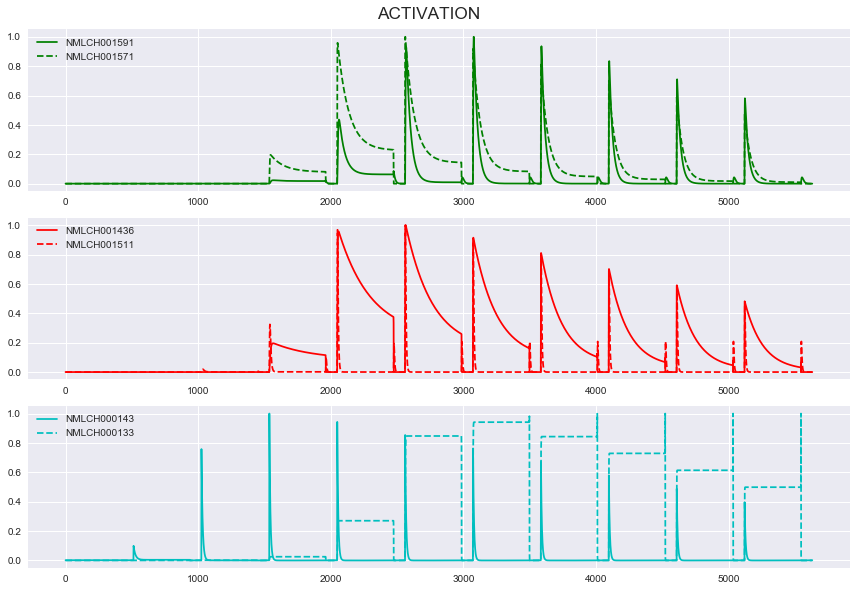

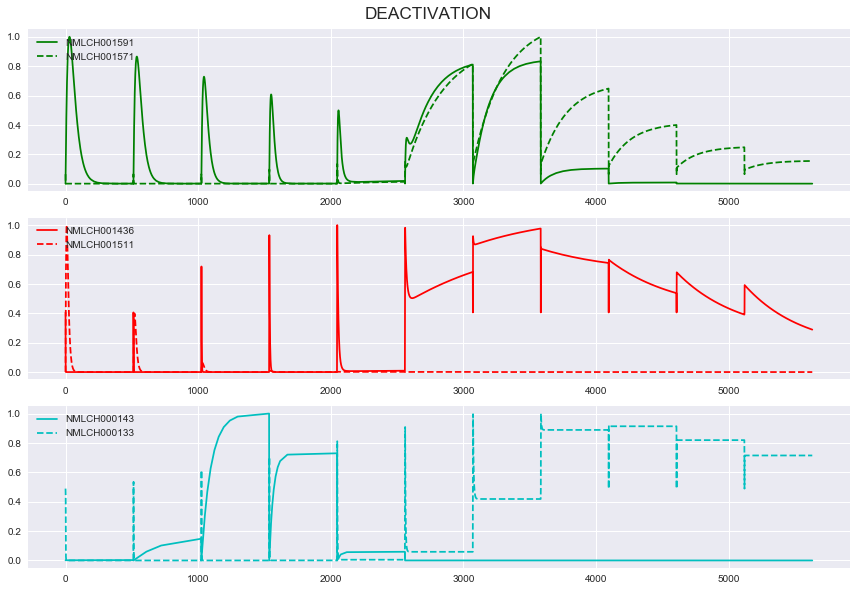

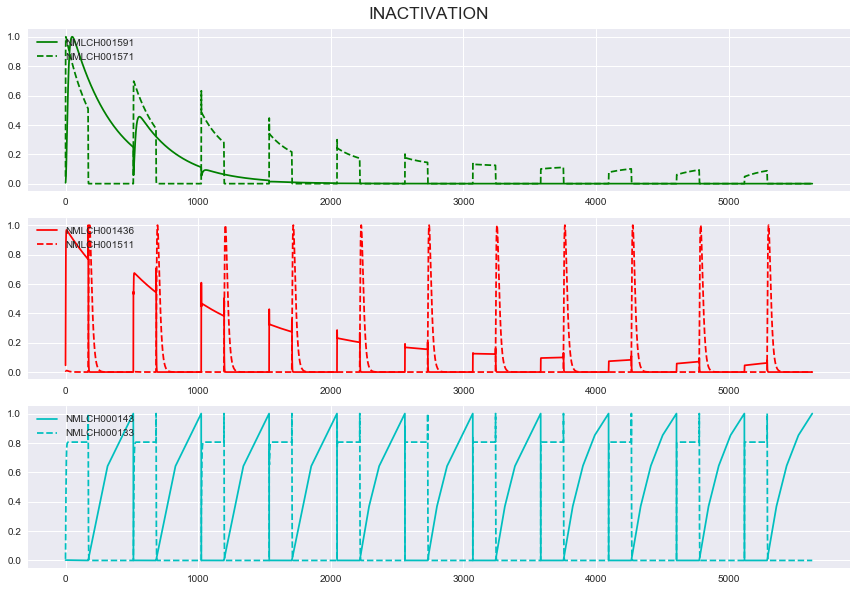

In [83]:
# Cav channels
num_cav_clusters = 3
cluster_colors = ['g','r','c']
cav_exemplars = [['NMLCH001591','NMLCH001571'],
                 ['NMLCH001436','NMLCH001511'],
                 ['NMLCH000143','NMLCH000133']]

protocols=['ACTIVATION','DEACTIVATION','INACTIVATION']


for protocol_id in protocols:
    
    fig, ax = plt.subplots(3,1,figsize=(12,8))

    for i, (color, exemplar_list) in enumerate(zip(cluster_colors,cav_exemplars)):

        num_traces = len(exemplar_list)

        traces_df = norm_cav_df[norm_cav_df['Model_ID'].isin(exemplar_list)]

        model_ids = traces_df.pop('Model_ID')
        channel_types = traces_df.pop('Channel_Type')

        protocol_traces_df = traces_df[traces_df['Protocol_ID']==protocol_id]
        protocols = protocol_traces_df.pop('Protocol_ID')

        plot_traces = protocol_traces_df.values

        for j, trace in enumerate(plot_traces):
            if j == 0:
                ax[i].plot(trace,color)
            else:
                color = color+'--'
                ax[i].plot(trace,color)
                
        ax[i].legend(exemplar_list,loc='upper left')
            
        fig.suptitle(protocol_id,y=1.02,size='xx-large')
        fig.tight_layout()
        
        
    filename = 'cav_'+protocol_id+'_exemplars'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,bbox_inches='tight')
        


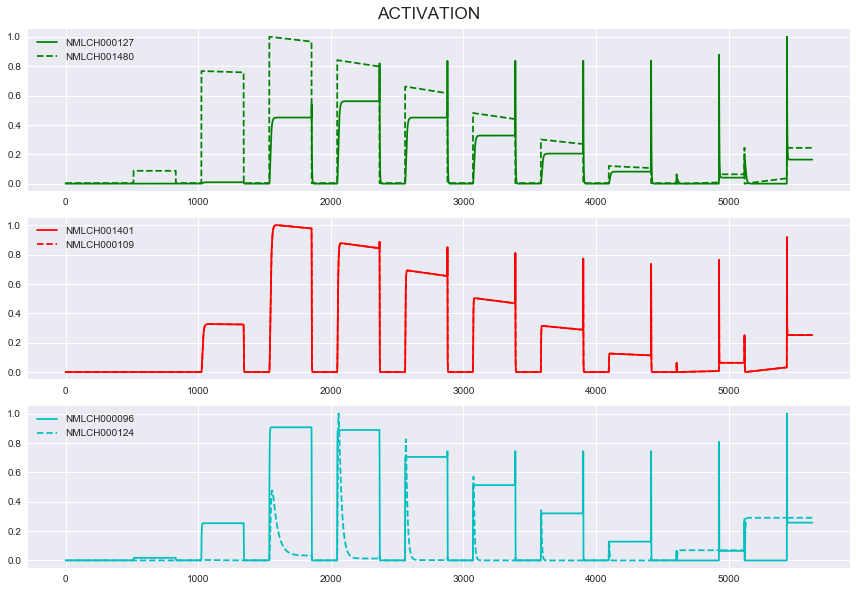

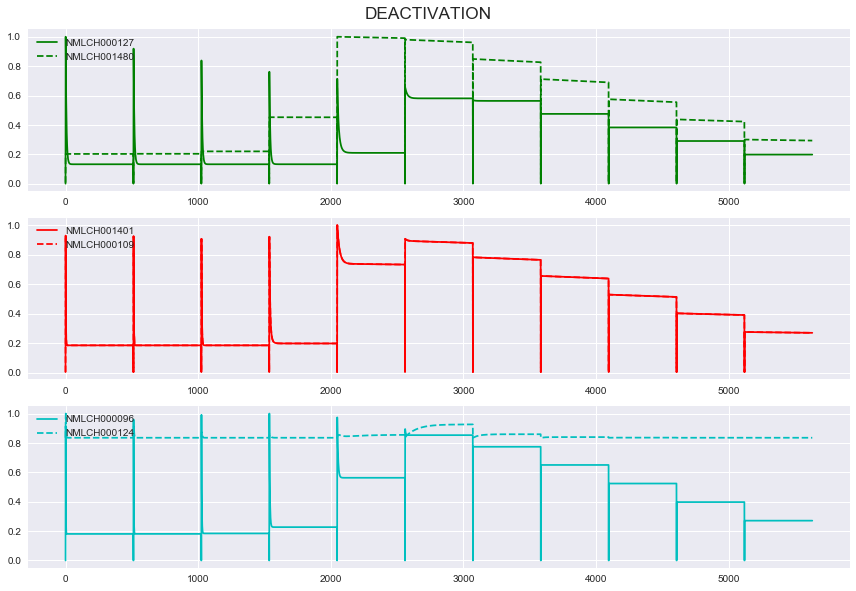

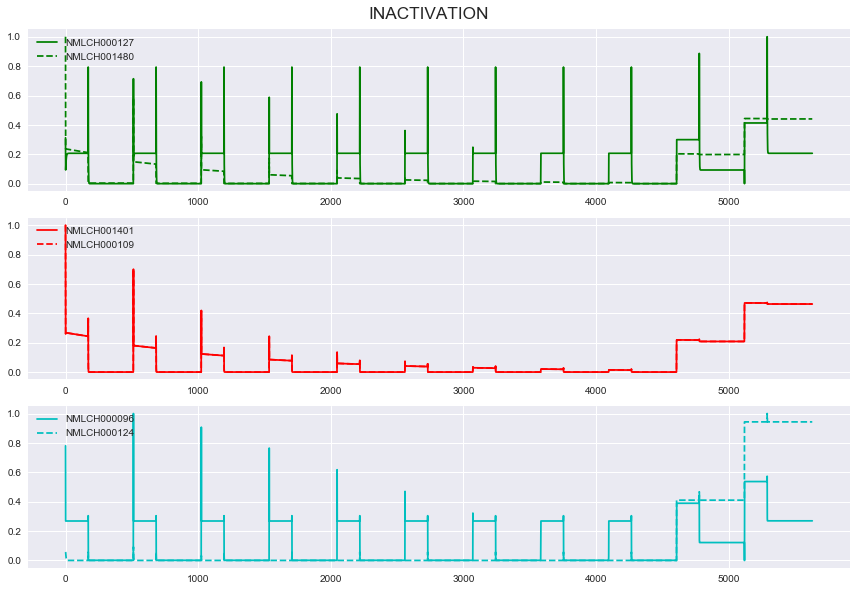

In [90]:
# Cav channels
num_pers_na_clusters = 3
cluster_colors = ['g','r','c']
nav_exemplars = [['NMLCH000127','NMLCH001480'],
                 ['NMLCH001401','NMLCH000109'],
                 ['NMLCH000096','NMLCH000124']]

norm_x_df = norm_nav_df

protocols=['ACTIVATION','DEACTIVATION','INACTIVATION']


for protocol_id in protocols:
    
    fig, ax = plt.subplots(3,1,figsize=(12,8))

    for i, (color, exemplar_list) in enumerate(zip(cluster_colors,nav_exemplars)):

        num_traces = len(exemplar_list)

        traces_df = norm_x_df[norm_x_df['Model_ID'].isin(exemplar_list)]

        model_ids = traces_df.pop('Model_ID')
        channel_types = traces_df.pop('Channel_Type')

        protocol_traces_df = traces_df[traces_df['Protocol_ID']==protocol_id]
        protocols = protocol_traces_df.pop('Protocol_ID')

        plot_traces = protocol_traces_df.values

        for j, trace in enumerate(plot_traces):
            if j == 0:
                ax[i].plot(trace,color)
            else:
                color = color+'--'
                ax[i].plot(trace,color)
                
        ax[i].legend(exemplar_list,loc='upper left')
            
        fig.suptitle(protocol_id,y=1.02,size='xx-large')
        fig.tight_layout()
        
        
    filename = 'nav_'+protocol_id+'_exemplars'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,bbox_inches='tight')
        



In [360]:
norm_cav_df[norm_cav_df['Model_ID']=='NMLCH000133']

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
27,-0.001614,-0.001620,-0.001627,-0.001633,-0.001639,-0.001645,-0.001651,-0.001657,-0.001662,-0.001668,...,1.548165e-03,1.557261e-03,1.566356e-03,1.575452e-03,1.584547e-03,1.593643e-03,1.602738e-03,NMLCH000133,ACTIVATION,Cav
28,-0.001402,-0.001404,-0.001406,-0.001409,-0.001411,-0.001414,-0.001416,-0.001419,-0.001421,-0.001423,...,-2.003478e-06,-1.671777e-06,-1.340075e-06,-1.008374e-06,-6.766728e-07,-3.449716e-07,-1.327036e-08,NMLCH000133,DEACTIVATION,Cav
29,15082.266249,14996.735516,14911.204784,14825.674051,14740.143318,14654.612586,14569.081853,14483.551120,14398.020387,14312.489655,...,5.930888e+06,5.939375e+06,5.947862e+06,5.956349e+06,5.964835e+06,5.973322e+06,5.981809e+06,NMLCH000133,INACTIVATION,Cav


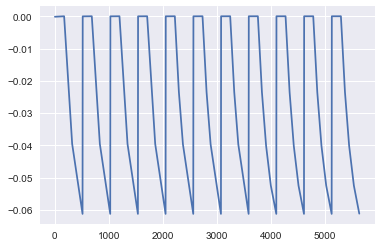

In [368]:
plt.plot(cav_responses_df.iloc[29].values[:-3])

<hr>

## Use run_channel_clustering.py 